# import

In [4]:
import numpy as np
import dimod
import dwave_networkx as dnx
import networkx as nx
import minorminer
import minorminer.layout as mml
%matplotlib inline
import dwave.inspector
import math
from datetime import datetime
from pathlib import Path  
import pandas as pd
import os

from matplotlib.pyplot import subplots
from matplotlib.table import Table
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools  



def Reverse(tup):
    newtup=(tup[1],tup[0])
    return newtup

all_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


# Functions and definitions

Need the following definitions

In [12]:
#array of A,B and the x and y shifts
Lx = 7; Ly = 7; #this is the max that can be done. 
#this is the plaquette values
array_AB = [['' for i in range(Ly)] for j in range(Lx)]
for ix in range(Lx):
    for iy in range(Ly):
        if ix%2 == 0:
            if iy%2 == 0:
                array_AB[ix][iy] = 'A'
            else:
                array_AB[ix][iy] = 'B'
        else:
            if iy%2 == 0:
                array_AB[ix][iy] = 'B'
            else:
                array_AB[ix][iy] = 'A'
array_AB = np.array(array_AB)

#array of A,B and the x and y shifts
#this is the plaquette values
array_shifts = np.empty((Lx, Ly,2))
for ix in range(Lx):
    for iy in range(Ly):        
        array_shifts[ix, iy] = [4 - (ix%2)*7,4 - (iy%2)*7]

plaquette_by_plaquette = []
for ix in range(Lx):
    for iy in range(Ly):
        translation_vector = [ix,iy] #
        plaquette_by_plaquette.append(tuple(translation_vector))


#####
#plotting the A/B sublattice structure
#####
ybond_qubit = np.ones((Lx, Ly+1))
xbond_qubit = np.ones((Lx+1, Ly))

# import

In [44]:
n = 0
inv_temp = 0.6
#inv_temp_range = [0.1, 0.3, 0.6, 0.8, 1.0]

folder = Path("./data/raw/" + "/" + "n=" + str(n) + "/" + "beta=" + str(inv_temp))
folder.mkdir(parents=True, exist_ok=True)
Name = 'forward_anneal_sol_' + str(0)
filepath = str(Path(folder, Name)) + '.npz'
file_import = np.load(filepath, allow_pickle=True)

#extract what is needed
record = file_import['resp']
all_plaquettes_mod = file_import['all_plaquettes_mod']
variables = file_import['variables']

The measurement of plaquettes and magnetization

In [39]:
#new plaquettes
plaq_variable_index_mod = []

single_qubits_mag = np.unique(all_plaquettes_mod)

#does not work yet, only works after a run has been done and an embedding is defined.
for i in range(int(len(all_plaquettes_mod)/4)):
    qubit_indices = all_plaquettes_mod[4*i:(4*i+4)]
    single_plaquette = []
    for k in range(4):
        where_is_it = np.where(np.array(variables) == qubit_indices[k])[0]
        if len(where_is_it) > 0:
            single_plaquette.append(where_is_it[0])
    if len(single_plaquette) != 4:
        print("woops")
    plaq_variable_index_mod.append(np.array(single_plaquette))
#print(plaq_variable_index_mod)

indices_for_mag = []
for i in range(len(single_qubits_mag)):
    where_is_it = np.where(np.array(variables) == single_qubits_mag[i])[0]
    if len(where_is_it) > 0:
        indices_for_mag.append(where_is_it[0])

#unit cells in the same order as the plaq_variable_index
unit_cell_after = plaquette_by_plaquette
all_avg = np.zeros((Lx,Ly))
all_avg_min = np.zeros((Lx,Ly))
#min_ene = response.record[0][1]
min_ene = np.min([record[i][1] for i in range(len(record))])
count = 0
mag_av = 0
mag_av_2 = 0
full_plaquette_per_resp = []
for resp in record:
    current_val = 0
    if resp[1] == min_ene:
        count += 1
        for k in range(len(plaq_variable_index_mod)):
            all_avg_min[unit_cell_after[k]] += np.prod(resp[0][plaq_variable_index_mod[k]])
    for k in range(len(plaq_variable_index_mod)):
        all_avg[unit_cell_after[k]] += np.prod(resp[0][plaq_variable_index_mod[k]])
        current_val += np.prod(resp[0][plaq_variable_index_mod[k]])

    for i in range(len(indices_for_mag)):
        mag_av += np.sum(resp[0][indices_for_mag[i]])
        mag_av_2 += np.sum(resp[0][indices_for_mag[i]]**2)
    full_plaquette_per_resp.append(current_val/(7*7))

print("percentage of samples in lowest energy state: ", 100*count/len(record))
print("avg value of Sum(P)/N for the lowest energy states: ", np.sum(all_avg_min/count)/(7*7))
print("avg value of Sum(P)/N for all states: ", np.sum(all_avg/len(record))/(7*7))
print("avg magnetization for all states: ", mag_av/len(record)/(7*7*4))

percentage of samples in lowest energy state:  0.5
avg value of Sum(P)/N for the lowest energy states:  -0.5102040816326531
avg value of Sum(P)/N for all states:  -0.17204081632653065
avg magnetization for all states:  -0.018214285714285714


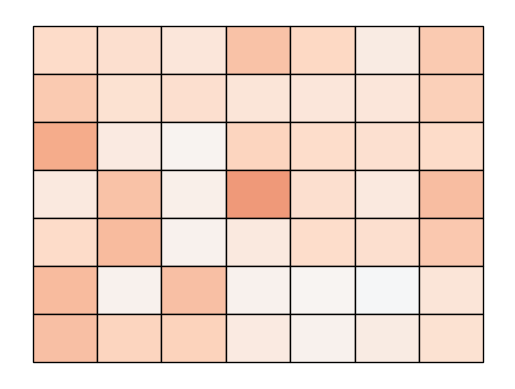

In [33]:
cmap = plt.colormaps['RdBu']
#norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)

#this is the plaquette values
ary = np.transpose(all_avg/len(record)) #plot over all obtained states
# ary = np.transpose(all_avg_min/count) #plot over only the lowest energy states
cell_colors=("white", "black")
font_colors=("black", "white")
node_colors = ("red", "blue")
fmt="%.2f"
figsize=None
fontsize=None
show_text = False

fig, ax = subplots(figsize=figsize)
ax.set_axis_off()
delta = 1/11/2
tb = Table(ax, bbox = [delta, delta, 1 - 2*delta, 1-2*delta])

n_rows, n_cols = ary.shape
width, height = 1.0/(n_rows + 1) , 1.0/(n_cols + 1)
for (row_idx, col_idx), cell_val in np.ndenumerate(ary):
    idx = (col_idx + row_idx) % 2
    color_code = int(cell_val > 0.5)
    # if show_text:
    #     text_in = fmt % cell_val
    # else:
    #     text_in = ""
    tb.add_cell(
        row_idx,
        col_idx,
        width,
        height,
        #text=text_in,
        loc="center",
        facecolor=cmap((cell_val + 1)/2),
    )
    #print(cmap(cell_val))
    #tb._cells[(row_idx, col_idx)]._text.set_color(font_colors[color_code])

tb.set_fontsize(fontsize)
ax.add_table(tb)


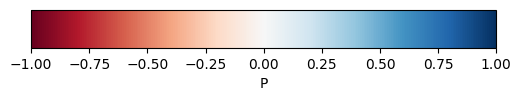

In [19]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cmap = plt.colormaps['RdBu']
norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('P')


histograms of the plaquette values

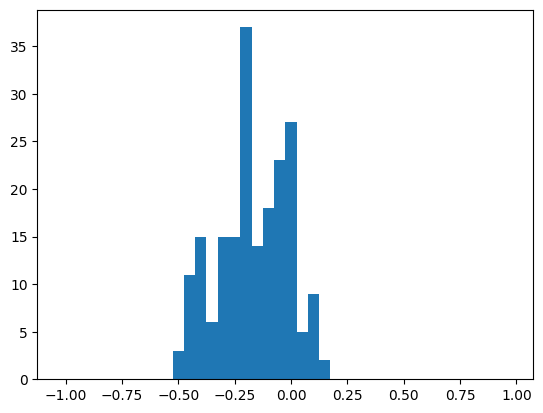

In [43]:
step = 0.05
plt.hist(full_plaquette_per_resp, bins = np.arange(-1, 1+step, step) - step/2);

# import a batch

In [87]:
n = 49
# inv_temp = 0.6
# inv_temp_range = [0.1, 0.3, 0.6, 0.8, 1.0]
inv_temp_range = 1 / np.linspace(1, 10, 20)

full_record = []

for inv_temp in inv_temp_range:
    folder = Path("./data/raw/" + "/" + "n=" + str(n) + "/" + "beta=" + str(inv_temp))
    folder.mkdir(parents=True, exist_ok=True)
    Name = 'forward_anneal_sol_' + str(0)
    filepath = str(Path(folder, Name)) + '.npz'
    file_import = np.load(filepath, allow_pickle=True)

    #extract what is needed
    full_record.append(file_import['resp'])
    all_plaquettes_mod = file_import['all_plaquettes_mod']
    variables = file_import['variables']

In [88]:
def measure_mag_per_config(resps, all_plaquettes_mod, variables):
    single_qubits_mag = np.unique(all_plaquettes_mod)
    indices_for_mag = []
    for i in range(len(single_qubits_mag)):
        where_is_it = np.where(np.array(variables) == single_qubits_mag[i])[0]
        if len(where_is_it) > 0:
            indices_for_mag.append(where_is_it[0])

    mag_av = []
    mag_av_2 = []
    for resp in resps:
        val1 = 0
        val2 = 0
        for i in range(len(indices_for_mag)):
            val1 += np.sum(resp[0][indices_for_mag[i]])
            val2 += np.sum(resp[0][indices_for_mag[i]])**2
        mag_av.append(val1)
        mag_av_2.append(val2)

    return mag_av, mag_av_2

def measure_plaquettes_per_config(resps, all_plaquettes_mod, variables):

    plaq_variable_index_mod = []
    for i in range(int(len(all_plaquettes_mod)/4)):
        qubit_indices = all_plaquettes_mod[4*i:(4*i+4)]
        single_plaquette = []
        for k in range(4):
            where_is_it = np.where(np.array(variables) == qubit_indices[k])[0]
            if len(where_is_it) > 0:
                single_plaquette.append(where_is_it[0])
        if len(single_plaquette) != 4:
            print("woops")
        plaq_variable_index_mod.append(np.array(single_plaquette))

    unit_cell_after = []
    for ix in range(7):
        for iy in range(7):
            unit_cell_after.append(tuple([ix,iy]))
    full_plaquette_per_resp = []
    all_avg = np.zeros((7,7))
    for resp in resps:
        current_val = 0
        for k in range(len(plaq_variable_index_mod)):
            all_avg[unit_cell_after[k]] += np.prod(resp[0][plaq_variable_index_mod[k]])
            current_val += np.prod(resp[0][plaq_variable_index_mod[k]])
        full_plaquette_per_resp.append(current_val/(7*7))
    
    return all_avg, full_plaquette_per_resp
    


In [89]:
data_for_parity_histo = []
labels = []
all_mag_data = []
all_plaquette_data = []
for i in range(len(full_record)):
    labels.append("beta=" + str(inv_temp_range[i]))
    avg_P, avg_per_config = measure_plaquettes_per_config(full_record[i], all_plaquettes_mod, variables)
    print('beta = ', inv_temp_range[i])
    print("avg value of Sum(P)/N for all states: ", np.sum(avg_P/len(full_record[i]))/(7*7))
    data_for_parity_histo.append(avg_per_config)
    mag1, mag2 = measure_mag_per_config(full_record[i], all_plaquettes_mod, variables)
    print("avg magnetization <sum_i sigma_i^z> for all states: ", np.sum(mag1)/len(full_record[i])/(7*7*4))
    print("avg magnetization <|sum_i sigma_i^z|^2> for all states: ", np.sum(mag2)/len(full_record[i])/(7*7*4))

    all_mag_data.append(np.sum(mag1)/len(full_record[i])/(7*7*4))
    all_plaquette_data.append(np.sum(avg_P/len(full_record[i]))/(7*7))


beta =  1.0
avg value of Sum(P)/N for all states:  0.8195918367346938
avg magnetization <sum_i sigma_i^z> for all states:  0.0038775510204081634
avg magnetization <|sum_i sigma_i^z|^2> for all states:  0.5714285714285714
beta =  0.6785714285714286
avg value of Sum(P)/N for all states:  0.6134693877551021
avg magnetization <sum_i sigma_i^z> for all states:  0.0326530612244898
avg magnetization <|sum_i sigma_i^z|^2> for all states:  0.5714285714285714
beta =  0.5135135135135136
avg value of Sum(P)/N for all states:  0.44469387755102047
avg magnetization <sum_i sigma_i^z> for all states:  0.030510204081632655
avg magnetization <|sum_i sigma_i^z|^2> for all states:  0.5714285714285714
beta =  0.41304347826086957
avg value of Sum(P)/N for all states:  0.3112244897959183
avg magnetization <sum_i sigma_i^z> for all states:  0.0638265306122449
avg magnetization <|sum_i sigma_i^z|^2> for all states:  0.5714285714285714
beta =  0.3454545454545455
avg value of Sum(P)/N for all states:  0.21795918

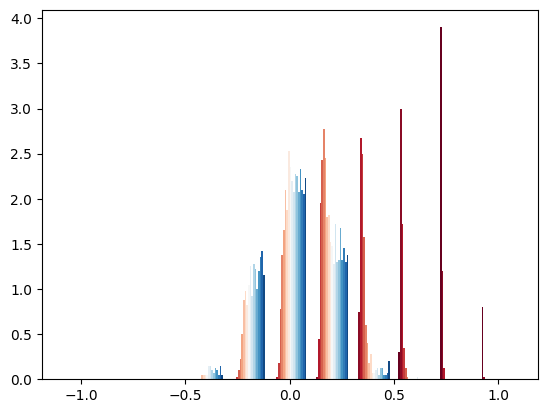

In [95]:
step = 0.2
# plt.hist(full_plaquette_per_resp, bins = np.arange(-1, 1+step, step) - step/2);
bin_range = np.arange(-1, 1+2*step, step) - step/2
# colors = all_colors[:len(data_for_parity_histo)]
cmap = plt.colormaps['RdBu']
colors = [cmap(i/len(data_for_parity_histo)) for i in range(len(data_for_parity_histo))]
plt.hist(data_for_parity_histo, bins = bin_range, density=True, histtype='bar', color=colors, label=labels);
# plt.legend(prop={'size': 10})


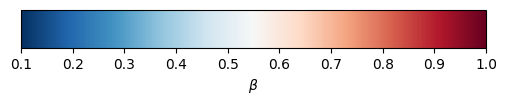

In [72]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cmap = plt.colormaps['RdBu_r']
norm = mpl.colors.Normalize(vmin=np.min(inv_temp_range), vmax=np.max(inv_temp_range))
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label(r'$\beta$')

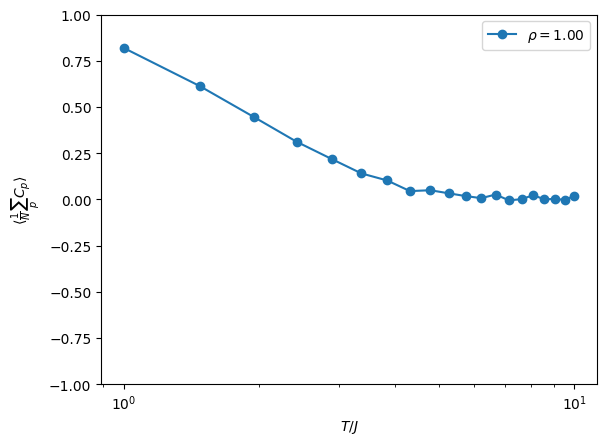

In [97]:
plt.plot(1/inv_temp_range, all_plaquette_data, 'o-', label = r'$\rho = ${:.2f}'.format(n/49))
# plt.plot(1/inv_temp_range, all_mag_data, 'o-', label = r'$\rho = ${:.2f}'.format(n/49))
plt.xscale('log')
plt.ylabel(r'$\langle \frac{1}{N} \sum_p C_p \rangle$')
# plt.ylabel(r'$\langle \frac{1}{N_s} \sum_i \sigma_i^z \rangle$')
plt.ylim([-1,1])
plt.legend()
plt.xlabel(r'$T/J$');